PROJECT - BRAIN TUMOR MRI CLASSIFIER

DEVELOPED BY - ISHAN MISHRA

# 🧪 EDA

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
base_path = '../Data/Tumour'  
splits = ['train', 'valid', 'test']
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

In [11]:
base_path = 'BrainTumorClassifier/Data/Tumour'

Count images per class per split

In [12]:
for split in splits:
    print(f"\n{split.upper()}:")
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len(os.listdir(folder))
        print(f"{cls}: {count} images")


TRAIN:
glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images

VALID:
glioma: 161 images
meningioma: 124 images
no_tumor: 99 images
pituitary: 118 images

TEST:
glioma: 80 images
meningioma: 63 images
no_tumor: 49 images
pituitary: 54 images


Visualize a few images from each class in train set

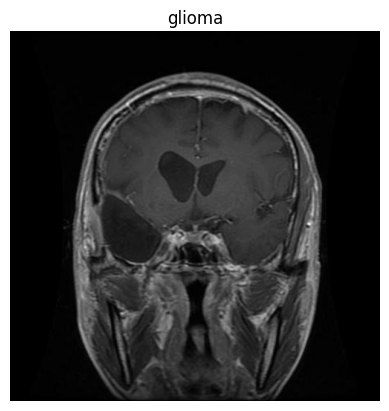

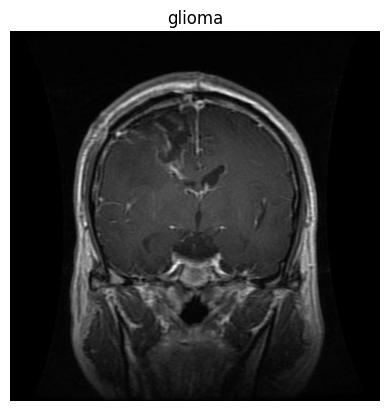

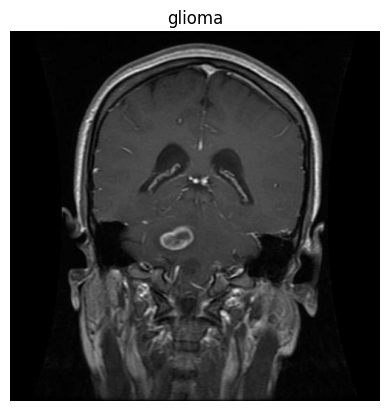

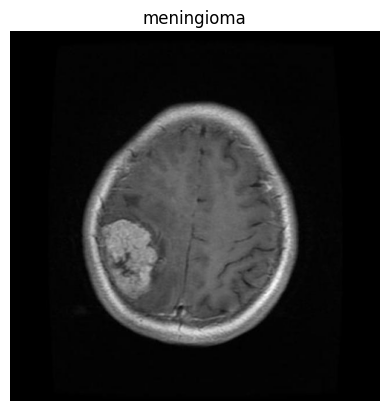

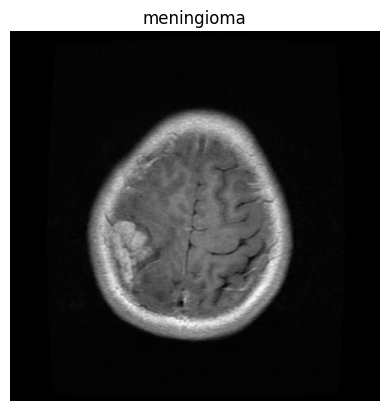

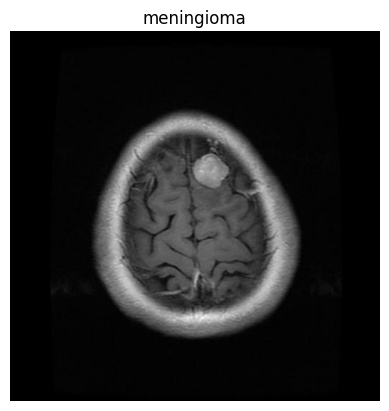

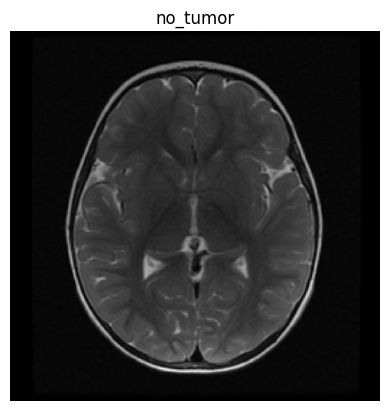

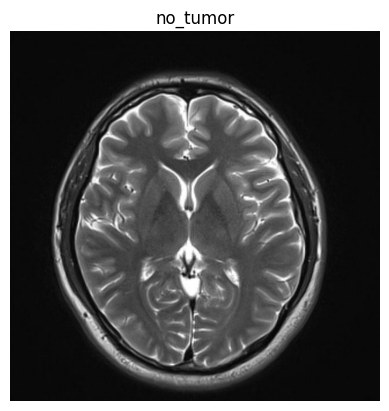

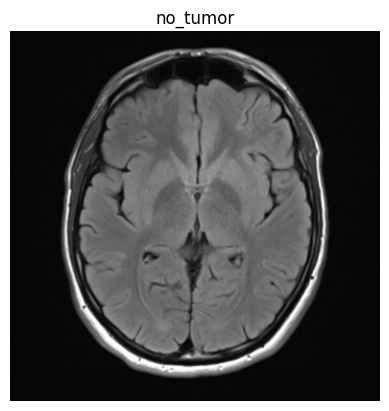

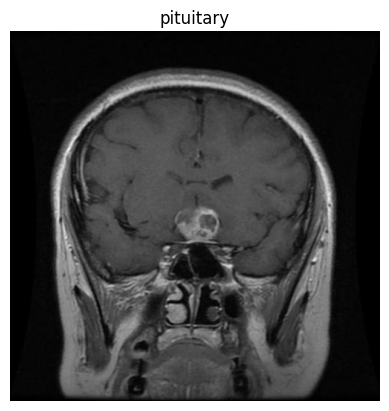

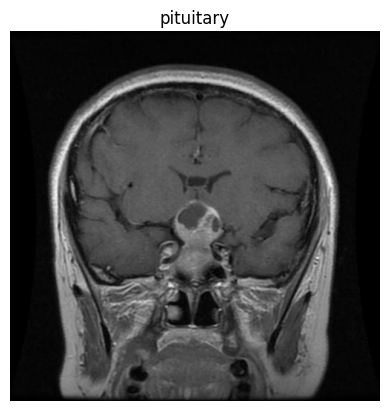

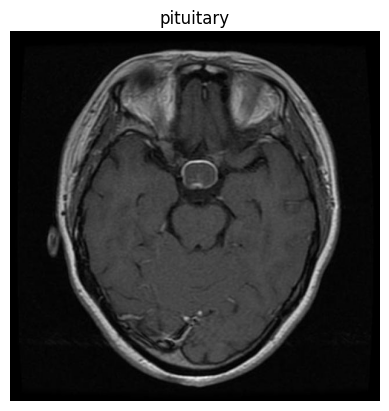

In [13]:
for cls in classes:
    folder = os.path.join(base_path, 'train', cls)
    img_names = os.listdir(folder)[:3]
    for img_name in img_names:
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis('off')
        plt.show()

Checking Image Consistency (image sizes and formats)

In [14]:
shapes = set()
formats = set()
for cls in classes:
    folder = os.path.join(base_path, 'train', cls)
    img_names = os.listdir(folder)[:10]
    for img_name in img_names:
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        shapes.add(img.size)
        formats.add(img.format)
print("Unique image sizes:", shapes)
print("Image formats:", formats)

Unique image sizes: {(640, 640)}
Image formats: {'JPEG'}


Visualizing class distribution

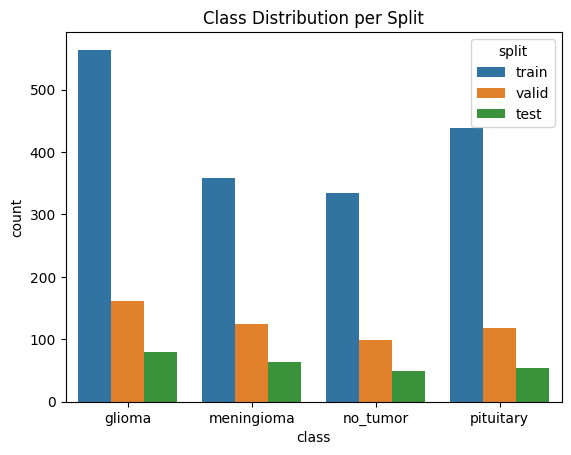

In [16]:
import seaborn as sns
import pandas as pd

counts = []
for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len(os.listdir(folder))
        counts.append({'split': split, 'class': cls, 'count': count})

df = pd.DataFrame(counts)
sns.barplot(data=df, x='class', y='count', hue='split')
plt.title('Class Distribution per Split')
plt.show()

# 🧠 Model Training

Data Preprocessing & Augmentation (PyTorch)

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

Define transformations for training and validation/test

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale; use 3 values for RGB
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Paths to your data folders

In [4]:
base_path = '../Data/Tumour'
train_dir = f'{base_path}/train'
val_dir = f'{base_path}/valid'
test_dir = f'{base_path}/test'

Create datasets

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

Create DataLoaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 1695
Validation samples: 502
Test samples: 246


Visualize Augmented Sample

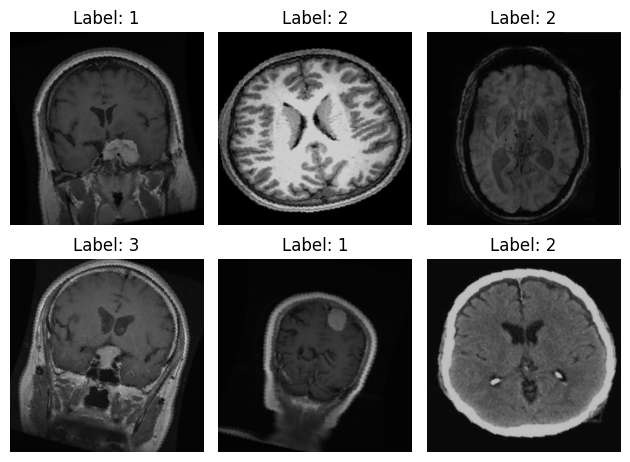

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images (iter returns first batch)
images, labels = next(iter(train_loader))

# Unnormalize and plot first 6 images
for i in range(6):
    img = images[i].numpy().transpose((1, 2, 0))  # add transpose here!
    img = img * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray' if img.shape[2]==1 else None)
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
model = model.to(device)

Using device: cpu


c:\Users\ishan\miniconda3\envs\tumour-py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ishan\miniconda3\envs\tumour-py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ishan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training & Validation Loop

In [11]:
num_epochs = 10  

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_corrects.double() / val_total

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 1/10 | Train Loss: 0.5720 | Train Acc: 0.7870 | Val Loss: 0.8548 | Val Acc: 0.7908
Epoch 2/10 | Train Loss: 0.2597 | Train Acc: 0.9032 | Val Loss: 0.4305 | Val Acc: 0.8466
Epoch 3/10 | Train Loss: 0.1692 | Train Acc: 0.9381 | Val Loss: 0.3811 | Val Acc: 0.8625
Epoch 4/10 | Train Loss: 0.1663 | Train Acc: 0.9510 | Val Loss: 0.4179 | Val Acc: 0.8685
Epoch 5/10 | Train Loss: 0.1251 | Train Acc: 0.9587 | Val Loss: 1.1636 | Val Acc: 0.7191
Epoch 6/10 | Train Loss: 0.1249 | Train Acc: 0.9599 | Val Loss: 0.2147 | Val Acc: 0.9382
Epoch 7/10 | Train Loss: 0.1488 | Train Acc: 0.9445 | Val Loss: 0.1861 | Val Acc: 0.9283
Epoch 8/10 | Train Loss: 0.1060 | Train Acc: 0.9587 | Val Loss: 0.1829 | Val Acc: 0.9442
Epoch 9/10 | Train Loss: 0.0720 | Train Acc: 0.9746 | Val Loss: 0.3410 | Val Acc: 0.9104
Epoch 10/10 | Train Loss: 0.0750 | Train Acc: 0.9740 | Val Loss: 0.2269 | Val Acc: 0.9263


In [12]:
torch.save(model.state_dict(), '../models/best_model.pth')
print('Model saved!')

Model saved!


Test Accuracy: 0.9512

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97        80
  meningioma       0.95      0.92      0.94        63
    no_tumor       0.92      0.92      0.92        49
   pituitary       0.98      0.96      0.97        54

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



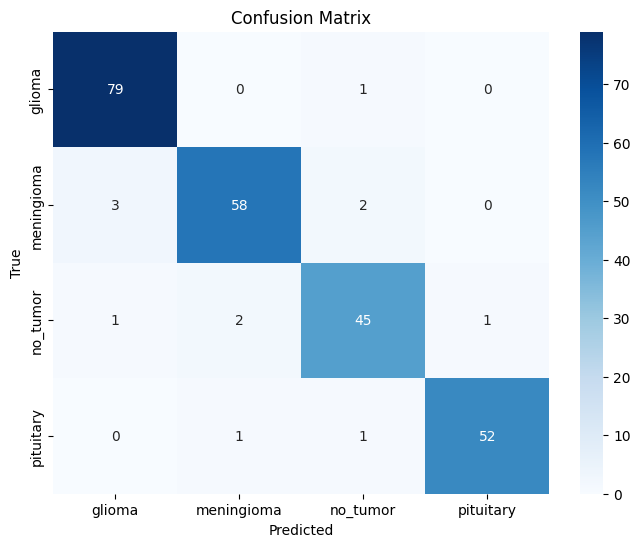

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
target_names = test_dataset.classes  # class names from ImageFolder
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 🌐 Streamlit App Code

In [ ]:
import streamlit as st
import torch
from torchvision import models, transforms
from PIL import Image
import os
import json

# --- Set Background ---
def set_bg(image_path):
    with open(image_path, "rb") as image_file:
        import base64
        encoded = base64.b64encode(image_file.read()).decode()
    page_bg_img = f"""
    <style>
    .stApp {{
      background-image: url("data:image/jpg;base64,{encoded}");
      background-size: cover;
      background-repeat: no-repeat;
      background-attachment: fixed;
    }}
    </style>
    """
    st.markdown(page_bg_img, unsafe_allow_html=True)

set_bg(os.path.join(os.path.dirname(__file__), "background.jpg"))

USERS_FILE = os.path.join(os.path.dirname(__file__), "users.json")

# --- User Auth Helpers ---
def load_users():
    if not os.path.exists(USERS_FILE):
        return {}
    with open(USERS_FILE, "r") as f:
        return json.load(f)

def save_users(users):
    with open(USERS_FILE, "w") as f:
        json.dump(users, f)

def signup_form():
    st.title("Sign Up")
    username = st.text_input("Choose a username")
    password = st.text_input("Choose a password", type="password")
    if st.button("Sign Up"):
        users = load_users()
        if username in users:
            st.error("Username already exists!")
        elif username == "" or password == "":
            st.error("Username and password cannot be empty!")
        else:
            users[username] = password
            save_users(users)
            st.success("Account created! Please sign in.")
            st.session_state["show_signup"] = False

def login_form():
    st.title("Sign In")
    username = st.text_input("Username")
    password = st.text_input("Password", type="password")
    if st.button("Sign In"):
        users = load_users()
        if username in users and users[username] == password:
            st.session_state['logged_in'] = True
            st.session_state['username'] = username
            st.success("Logged in!")
        else:
            st.error("Invalid credentials.")

# --- Model Loading ---
def load_model():
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 4)
    model_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '../models/best_model.pth'))
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

@st.cache_resource
def get_model():
    return load_model()

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return transform(image).unsqueeze(0)

def main_app():
    st.markdown(
    """
    <style>
    div[data-testid="stTextInput"] > div > input,
    div[data-testid="stTextArea"] > div > textarea,
    div[data-testid="stNumberInput"] > div > input {
        background: #00bfff !important;         /* Neon blue background */
        border: 2px solid #00fff7 !important;   /* Bright neon border */
        border-radius: 15px !important;
        color: #fff !important;                 /* White text */
        box-shadow: 0 0 15px #00eaff, 0 0 4px #00fff7 !important;
        padding: 0.75em !important;
        font-size: 1.1em !important;
        outline: none !important;
        transition: box-shadow 0.3s, border 0.3s;
    }
    div[data-testid="stTextInput"] > div > input:focus,
    div[data-testid="stTextArea"] > div > textarea:focus,
    div[data-testid="stNumberInput"] > div > input:focus {
        box-shadow: 0 0 25px #00ffff, 0 0 8px #00fff7 !important;
        border: 2.5px solid #00fff7 !important;
    }
    label {
        color: #fff !important;
        text-shadow: 0 0 5px #00bfff;
        font-weight: bold !important;
    }
    </style>
    """, unsafe_allow_html=True
)
    st.markdown('<div class="big-font">MRI Tumor Classifier</div>', unsafe_allow_html=True)
    st.write(f"<span style='color:#fff;'>Welcome, <b>{st.session_state['username']}</b>!</span>", unsafe_allow_html=True)
    st.markdown('<div class="contrast-box">', unsafe_allow_html=True)
    name = st.text_input("Your Name")
    age = st.number_input("Age", min_value=0, max_value=120, step=1)
    phone = st.text_input("Phone Number")
    med_hist = st.text_area("Any Medical History?")
    st.markdown('</div>', unsafe_allow_html=True)

    if not name or not phone or not age:
        st.warning("Please fill in all personal details before uploading MRI.")
        return

    uploaded_file = st.file_uploader("Upload an MRI Image", type=["png", "jpg", "jpeg"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded MRI", use_container_width=True)
        input_tensor = preprocess_image(image)
        with torch.no_grad():
            outputs = get_model()(input_tensor)
            _, pred = torch.max(outputs, 1)
            result = class_names[pred.item()]
            st.markdown(
                f"<div style='background:#0078D7; color:white; border-radius:6px; padding:12px; margin-top:20px; text-align:center; font-size:24px;'>"
                f"<b>Prediction: {result.upper()}</b></div>",
                unsafe_allow_html=True,
            )
            st.markdown(
                f"<div style='background:#222; color:#fff; border-radius:6px; padding:12px; margin-top:20px;'><b>Patient Info:</b><br>"
                f"Name: {name}<br>Age: {age}<br>Phone: {phone}<br>Medical History: {med_hist}</div>",
                unsafe_allow_html=True,
            )

# --- State Management ---
if 'logged_in' not in st.session_state:
    st.session_state['logged_in'] = False
if 'show_signup' not in st.session_state:
    st.session_state['show_signup'] = False

# --- UI Routing ---
if not st.session_state['logged_in']:
    if st.session_state['show_signup']:
        signup_form()
        if st.button("Already have an account? Sign In"):
            st.session_state['show_signup'] = False
    else:
        login_form()
        if st.button("Don't have an account? Sign Up"):
            st.session_state['show_signup'] = True
else:
    main_app()